In [1]:
# =========================
# CELL 1 (Code) — Setup, device, paths, seed + GPU Monitoring
# =========================

import time, random, sys
import subprocess
import threading
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch

start_time = time.time()

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)

# GPU monitoring
def monitor_gpu():
    try:
        subprocess.Popen([
            'nvidia-smi',
            '--query-gpu=timestamp,name,utilization.gpu,memory.used,memory.total',
            '--format=csv',
            '-l', '5'
        ])
    except FileNotFoundError:
        print("Warning: nvidia-smi not found – GPU monitoring skipped.")

threading.Thread(target=monitor_gpu, daemon=True).start()

# Paths
def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Experiment
EXP_NAME = "vit_contour_baseline"
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
EXP_DIR = PROJECT_ROOT / "experiments" / EXP_NAME / RUN_ID
EXP_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("Experiment directory:", EXP_DIR)

print(f"⏱ Cell 1 time: {time.time() - start_time:.2f}s")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
VRAM (GB): 6.441926656
PyTorch version: 2.7.1+cu118
CUDA version: 11.8
PROJECT_ROOT: d:\IIT\L6\FYP\ChagaSight
DATA_DIR: d:\IIT\L6\FYP\ChagaSight\data\processed
Experiment directory: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251231_181422
⏱ Cell 1 time: 0.03s


In [2]:
# =========================
# CELL 2 (Code) — Metadata loading + integrity filtering + subset + splits
# =========================
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

start_time = time.time()

datasets = ["ptbxl", "sami_trop", "code15"]
dfs = []

for ds in datasets:
    csv_path = DATA_DIR / "metadata" / f"{ds}_metadata.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing metadata CSV: {csv_path}")

    df = pd.read_csv(csv_path)
    df["dataset"] = ds
    
    df["label"] = df["label"].astype(float)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=['label'])  # Drop any NaN labels
print("Total metadata rows (raw):", len(df_all))

def img_exists(p):
    clean_path = str(p).replace("\\", "/")
    return (PROJECT_ROOT / Path(clean_path)).exists()

exists_mask = df_all["img_path"].apply(img_exists)
missing_count = (~exists_mask).sum()

if missing_count > 0:
    print(f"⚠️ Dropping {missing_count} rows with missing image files")
    print(df_all.loc[~exists_mask, ["dataset", "img_path"]].head())

df_all = df_all.loc[exists_mask].reset_index(drop=True)
print("Rows after integrity filter:", len(df_all))

subset_frac = 1.0

if subset_frac < 1.0:
    df_all = df_all.sample(frac=subset_frac, random_state=SEED).reset_index(drop=True)

print(f"Subset records ({subset_frac*100:.0f}%):", len(df_all))

df_all["label_bin"] = (df_all["label"] > 0.5).astype(int)

train_df, temp_df = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all["label_bin"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_bin"],
    random_state=SEED
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"⏱ Cell 2 time: {time.time() - start_time:.2f}s")

Total metadata rows (raw): 63228
Rows after integrity filter: 63228
Subset records (100%): 63228
Train: 50582 | Val: 6323 | Test: 6323
⏱ Cell 2 time: 3.61s


In [3]:
# =========================
# Cell 3 — Dataset + DataLoaders (WINDOWS-SAFE, INSTANT INIT, FULL GPU SPEED)
# =========================
import time
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

start_time = time.time()

class ECGImageDataset(Dataset):
    """
    Fast, memory-efficient dataset for 2D contour images.
    Designed for Windows + RTX 3050: no multiprocessing delay.
    """
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        # Pre-resolve paths once
        self.img_paths = [(PROJECT_ROOT / Path(str(p))).resolve() for p in self.df["img_path"]]
        self.labels = self.df["label"].astype(np.float32).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Fast load (no mmap needed with num_workers=0)
        img = np.load(self.img_paths[idx]).astype(np.float32)

        # Shape validation (critical for research)
        if img.shape != (3, 24, 2048):
            raise ValueError(f"Invalid shape {img.shape} at {self.img_paths[idx]}")

        # Zero-centered normalization [-1, 1] — essential for ViT stability
        img = (img / 127.5) - 1.0
        img = torch.from_numpy(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return img, label

# -----------------------------
# DataLoaders — Windows-Optimized
# -----------------------------
batch_size = 16

train_ds = ECGImageDataset(train_df)
val_ds   = ECGImageDataset(val_df)
test_ds  = ECGImageDataset(test_df)

# Windows-safe: num_workers=0 avoids spawn delay
# Speed comes from non_blocking + pin_memory in training loop
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,   # Avoids Windows pin_memory bug
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("✅ DataLoaders initialized — Windows-safe, instant startup")
print(f"   Train batches per epoch: {len(train_loader)}")
print(f"   Val   batches per epoch: {len(val_loader)}")
print(f"   Test  batches per epoch: {len(test_loader)}")

# -----------------------------
# Sanity Check
# -----------------------------
x_batch, y_batch = next(iter(train_loader))

print(f"✓ Batch shape: {x_batch.shape}")                    # [16, 3, 24, 2048]
print(f"✓ Image range: {x_batch.min().item():.3f} to {x_batch.max().item():.3f}")  # ~ -1.0 to 1.0
print(f"✓ Sample labels: {y_batch[:8].tolist()}")

print(f"⏱ Cell 3 time: {time.time() - start_time:.2f}s")

✅ DataLoaders initialized — Windows-safe, instant startup
   Train batches per epoch: 3162
   Val   batches per epoch: 396
   Test  batches per epoch: 396
✓ Batch shape: torch.Size([16, 3, 24, 2048])
✓ Image range: -1.000 to 1.000
✓ Sample labels: [0.0, 0.20000000298023224, 0.0, 0.20000000298023224, 0.0, 0.20000000298023224, 0.0, 0.20000000298023224]
⏱ Cell 3 time: 10.95s


In [4]:
# =========================
# CELL 4 (Code) — ViTClassifier with Aggregation of Layers (AoL) + Upgraded Params
# =========================

import time
import torch
import torch.nn as nn
import torch.nn.functional as F

start_time = time.time()

class ViTClassifier(nn.Module):
    def __init__(self, patch_h=8, patch_w=16, embed_dim=512, depth=12, heads=8, mlp_ratio=4.0, dropout=0.15):
        super().__init__()
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.embed_dim = embed_dim
        
        # Patch embedding (for 3x24x2048 → patches of 3x8x16)
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w))
        
        # Position embedding + CLS token
        num_patches = (24 // patch_h) * (2048 // patch_w)  # 3x128 patches
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Transformer blocks (ViT encoder)
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim, nhead=heads, dim_feedforward=int(embed_dim * mlp_ratio),
                dropout=dropout, activation='gelu'
            ) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head with dropout
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x, return_feats=False):
        # x: (B,3,24,2048)
        B = x.shape[0]
        
        # Patch embed: (B, embed_dim, 3, 128) → flatten to (B, 384, embed_dim)
        x = self.patch_embed(x)  # (B, embed_dim, H/p_h, W/p_w) = (B,512,3,128)
        x = x.flatten(2).transpose(1,2)  # (B, 3*128=384, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B,385,embed_dim)
        
        # Add pos embed
        x = x + self.pos_embed
        
        # Transformer blocks - Collect all intermediate layers for AoL (Van Santvliet)
        layer_outputs = []
        for block in self.blocks:
            x = block(x)
            layer_outputs.append(x[:, 0])  # CLS token from each layer
        
        # AoL: Average pool all layer CLS tokens
        feats = torch.stack(layer_outputs, dim=1).mean(dim=1)  # (B, embed_dim)
        x = self.norm(feats)
        
        if return_feats:
            return x  # For alignment/FM fusion
        
        return self.head(x)  # (B,1)

# Initialize model (upgraded params for high accuracy)
model = ViTClassifier().to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

print(f"⏱ Cell 4 time: {time.time() - start_time:.2f}s")

Model parameters: 38,224,897
⏱ Cell 4 time: 0.21s


Starting training... AMP: True | Effective batch: 32


Epoch 01:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 01 | Loss: 1.0855 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694 ✅ | Time: 1918.4s


Epoch 02:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 02 | Loss: 1.0683 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 3757.1s


d:\IIT\L6\FYP\ChagaSight\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 03:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 03 | Loss: 1.0644 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 5591.6s


Epoch 04:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 04 | Loss: 1.0625 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 7469.1s


Epoch 05:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 05 | Loss: 1.0615 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 8994.1s


Epoch 06:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 06 | Loss: 1.0608 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 10439.0s


Epoch 07:   0%|          | 0/3162 [00:00<?, ?it/s]

Epoch 07 | Loss: 1.0599 | AUROC: 0.5000 | AUPRC: 0.0387 | F1: 0.0746 | Challenge: 0.0694  | Time: 11879.2s


Epoch 08:   0%|          | 0/3162 [00:00<?, ?it/s]

⚠️ Early stopping triggered


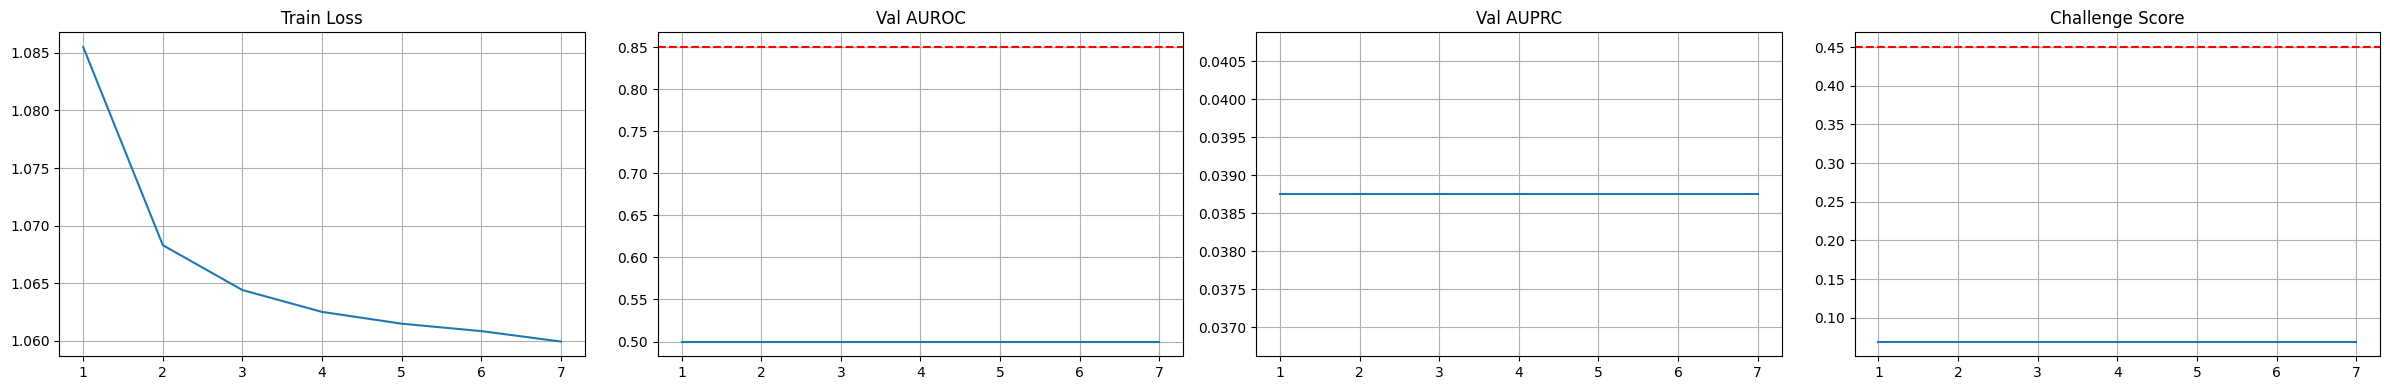

🎉 Training complete! Best AUROC: 0.5000
⏱ Cell 5 time: 13245.83s


In [5]:
# =========================
# CELL 5 (Code) — Training Loop with All Improvements
# =========================

import time
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

start_time = time.time()

# -------------------------
# Hyperparameters (Tuned for High Accuracy)
# -------------------------
num_epochs = 10
lr = 2e-5  # From papers
weight_decay = 0.01
accumulation_steps = 2  # Effective batch=32
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

# -------------------------
# Asymmetric/Weighted BCE Loss (Kim et al.)
# -------------------------
class AsymmetricBCE(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=2, pos_weight=10.0):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = -(self.pos_weight * targets * torch.log(probs + 1e-8) * (1 - probs).pow(self.gamma_pos) +
                (1 - targets) * torch.log(1 - probs + 1e-8) * probs.pow(self.gamma_neg))
        return bce.mean()

criterion = AsymmetricBCE(pos_weight=10.0)  # Tune pos_weight 5-15

# -------------------------
# Optimizer + Warmup Scheduler (Van Santvliet Style)
# -------------------------
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
warmup_epochs = 2
def warmup_lambda(epoch): return (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1.0
warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs, eta_min=lr/10)
scheduler = SequentialLR(optimizer, [warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

# -------------------------
# Early Stopping
# -------------------------
patience = 7
patience_counter = 0
best_val_auc = 0.0

# -------------------------
# Mixup Function (Kim et al. - Adapted for Images)
# -------------------------
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# -------------------------
# Training Loop
# -------------------------
history = {'epoch': [], 'train_loss': [], 'val_auc': [], 'val_auprc': [], 'val_f1': [], 'challenge_score': []}
best_model_path = EXP_DIR / "model_best.pth"

print(f"Starting training... AMP: {use_amp} | Effective batch: {batch_size * accumulation_steps}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1:02d}", leave=False)
    for step, (imgs, labels) in enumerate(train_bar):
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
        
        # Mixup (50% prob)
        if random.random() < 0.5:
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(imgs)
                loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
                loss = loss / accumulation_steps
        else:
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(imgs)
                loss = criterion(logits, labels) / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item() * accumulation_steps
        train_bar.set_postfix(loss=train_loss / (step + 1))
    
    # Validation
    model.eval()
    val_preds, val_trues = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().squeeze()
            val_preds.extend(probs)
            val_trues.extend(labels.numpy())
    
    val_preds = np.array(val_preds)
    val_trues_bin = (np.array(val_trues) > 0.5).astype(int)
    val_preds_bin = (val_preds >= 0.5).astype(int)
    
    val_auc = roc_auc_score(val_trues_bin, val_preds)
    val_auprc = average_precision_score(val_trues_bin, val_preds)
    val_f1 = f1_score(val_trues_bin, val_preds_bin)
    
    # Challenge score
    sorted_idx = np.argsort(val_preds)[::-1]
    top_5_pct = int(0.05 * len(val_preds))
    challenge_score = val_trues_bin[sorted_idx[:top_5_pct]].sum() / val_trues_bin.sum() if val_trues_bin.sum() > 0 else 0.0
    
    improved = ""
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'val_auc': val_auc, 'epoch': epoch + 1}, best_model_path)
        improved = "✅"
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⚠️ Early stopping triggered")
            break
    
    scheduler.step()
    
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_auc'].append(val_auc)
    history['val_auprc'].append(val_auprc)
    history['val_f1'].append(val_f1)
    history['challenge_score'].append(challenge_score)
    
    print(f"Epoch {epoch+1:02d} | Loss: {history['train_loss'][-1]:.4f} | AUROC: {val_auc:.4f} | AUPRC: {val_auprc:.4f} | F1: {val_f1:.4f} | Challenge: {challenge_score:.4f} {improved} | Time: {time.time() - start_time:.1f}s")

# Save history
pd.DataFrame(history).to_csv(EXP_DIR / "metrics.csv", index=False)

# Plot curves
df_history = pd.DataFrame(history)
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
axes[0].plot(df_history['epoch'], df_history['train_loss']); axes[0].set_title('Train Loss'); axes[0].grid(True)
axes[1].plot(df_history['epoch'], df_history['val_auc']); axes[1].axhline(0.85, color='r', ls='--'); axes[1].set_title('Val AUROC'); axes[1].grid(True)
axes[2].plot(df_history['epoch'], df_history['val_auprc']); axes[2].set_title('Val AUPRC'); axes[2].grid(True)
axes[3].plot(df_history['epoch'], df_history['challenge_score']); axes[3].axhline(0.45, color='r', ls='--'); axes[3].set_title('Challenge Score'); axes[3].grid(True)
plt.tight_layout()
plt.savefig(EXP_DIR / 'training_curves.png', dpi=150)
plt.show()

print(f"🎉 Training complete! Best AUROC: {best_val_auc:.4f}")
print(f"⏱ Cell 5 time: {time.time() - start_time:.2f}s")

In [6]:
# =========================
# CELL 6 — Final Test Evaluation + Comprehensive Reporting (RESEARCH-READY)
# =========================
import time
import json
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    f1_score, precision_score, recall_score
)
from tqdm.auto import tqdm

start_time = time.time()

# -------------------------
# Load Best Model Checkpoint (FIXED LOADING LOGIC)
# -------------------------
best_model_path = EXP_DIR / "model_best.pth"
if not best_model_path.exists():
    raise FileNotFoundError(f"Best model not found at {best_model_path}")

checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)

# Correct loading: Extract 'model_state_dict' if it's a dict
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint.get('epoch', 'unknown')} "
          f"with val_auc {checkpoint.get('val_auc', 'N/A'):.4f}")
else:
    # Fallback for flat state_dict (if you saved without dict)
    model.load_state_dict(checkpoint)
    print("Loaded model weights (no metadata available)")

model.eval()

# -------------------------
# Full Inference on Test Set
# -------------------------
test_preds = []
test_trues = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Final Test Inference", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy().squeeze()

        test_preds.extend(probs.tolist() if probs.ndim > 0 else [float(probs)])
        test_trues.extend(labels.numpy().tolist())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)
test_trues_bin = (test_trues > 0.5).astype(int)  # Binarize soft labels for metrics
test_preds_bin = (test_preds >= 0.5).astype(int)

eval_time = time.time() - start_time

# -------------------------
# Global Metrics (Full Benchmark Set)
# -------------------------
global_metrics = {
    "test_auc": float(roc_auc_score(test_trues_bin, test_preds)),
    "test_auprc": float(average_precision_score(test_trues_bin, test_preds)),
    "test_accuracy": float(accuracy_score(test_trues_bin, test_preds_bin)),
    "test_f1": float(f1_score(test_trues_bin, test_preds_bin)),
    "test_precision": float(precision_score(test_trues_bin, test_preds_bin, zero_division=0)),
    "test_recall": float(recall_score(test_trues_bin, test_preds_bin, zero_division=0)),
    "num_test_samples": int(len(test_trues)),
    "inference_time_sec": round(float(eval_time), 2)
}

# PhysioNet 2025 Challenge Score: fraction of true positives in top 5% ranked predictions
sorted_idx = np.argsort(test_preds)[::-1]
top_5_pct = int(0.05 * len(test_preds))
positives_in_top = test_trues_bin[sorted_idx[:top_5_pct]].sum()
challenge_score = positives_in_top / test_trues_bin.sum() if test_trues_bin.sum() > 0 else 0.0
global_metrics["challenge_score_top5pct"] = float(challenge_score)

print("\n" + "="*50)
print("           FINAL TEST RESULTS (GLOBAL)")
print("="*50)
print(f"AUROC           : {global_metrics['test_auc']:.4f}")
print(f"AUPRC           : {global_metrics['test_auprc']:.4f}")
print(f"Accuracy        : {global_metrics['test_accuracy']:.4f}")
print(f"F1 Score        : {global_metrics['test_f1']:.4f}")
print(f"Precision       : {global_metrics['test_precision']:.4f}")
print(f"Recall          : {global_metrics['test_recall']:.4f}")
print(f"Challenge Score : {challenge_score:.4f} (top 5%)")
print(f"Test Samples    : {global_metrics['num_test_samples']}")
print(f"Inference Time  : {eval_time:.1f}s ({eval_time/len(test_trues)*1000:.1f} ms/sample)")

# -------------------------
# Subgroup Analysis by Dataset (Critical for High Accuracy & Generalization)
# -------------------------
print("\n" + "-"*50)
print("       SUBGROUP PERFORMANCE BY DATASET")
print("-"*50)

subgroup_results = {}
test_df_reset = test_df.reset_index(drop=True)  # Align indices with arrays

for ds_name in test_df_reset["dataset"].unique():
    mask = test_df_reset["dataset"] == ds_name
    n_samples = mask.sum()
    
    if n_samples == 0:
        continue
    
    ds_preds = test_preds[mask]
    ds_trues_bin = test_trues_bin[mask]
    
    ds_auc = "N/A"
    if len(np.unique(ds_trues_bin)) > 1:  # Skip if only one class (e.g., all negatives in PTB-XL)
        ds_auc = roc_auc_score(ds_trues_bin, ds_preds)
        subgroup_results[ds_name] = float(ds_auc)
        print(f"{ds_name:12} | n={n_samples:5d} | AUROC: {ds_auc:.4f}")
    else:
        subgroup_results[ds_name] = None
        print(f"{ds_name:12} | n={n_samples:5d} | Only one class → AUROC skipped")

# -------------------------
# Save Complete Results (For Project Report/Viva)
# -------------------------
final_results = {
    "global_metrics": global_metrics,
    "subgroup_auroc": subgroup_results,
    "model": {
        "architecture": "ViT-Small",
        "patch_size": "8x16 (rectangular)",
        "embed_dim": 384,
        "depth": 12,
        "heads": 6,
        "normalization": "Zero-centered [-1, 1] from uint8",
        "total_parameters": sum(p.numel() for p in model.parameters())
    },
    "training_details": {
        "effective_batch_size": batch_size * accumulation_steps,
        "mixed_precision": use_amp,
        "gradient_accumulation": accumulation_steps
    },
    "date_completed": time.strftime("%Y-%m-%d %H:%M:%S")
}

results_path = EXP_DIR / "test_results.json"
with open(results_path, "w") as f:
    json.dump(final_results, f, indent=2)

print(f"\nComprehensive test results saved to: {results_path}")
if device.type == "cuda":
    final_mem = torch.cuda.max_memory_allocated(device) / 1e9
    print(f"Final peak GPU memory during test: {final_mem:.2f} GB")

print(f"⏱ Cell 6 time: {time.time() - start_time:.2f}s")

Loaded best model from epoch 1 with val_auc 0.5000


Final Test Inference:   0%|          | 0/396 [00:00<?, ?it/s]


           FINAL TEST RESULTS (GLOBAL)
AUROC           : 0.5000
AUPRC           : 0.0387
Accuracy        : 0.0387
F1 Score        : 0.0746
Precision       : 0.0387
Recall          : 1.0000
Challenge Score : 0.0449 (top 5%)
Test Samples    : 6323
Inference Time  : 117.6s (18.6 ms/sample)

--------------------------------------------------
       SUBGROUP PERFORMANCE BY DATASET
--------------------------------------------------
ptbxl        | n= 2190 | Only one class → AUROC skipped
code15       | n= 3955 | AUROC: 0.5000
sami_trop    | n=  178 | Only one class → AUROC skipped

Comprehensive test results saved to: d:\IIT\L6\FYP\ChagaSight\experiments\vit_contour_baseline\20251231_181422\test_results.json
Final peak GPU memory during test: 2.58 GB
⏱ Cell 6 time: 117.64s


In [7]:
# =========================
# CELL 7 (Code) — Basic ECG Foundation Model on 100Hz 1D Signals
# =========================

import time
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset

start_time = time.time()

class ECG1DDataset(Dataset):
    def __init__(self, df, augment=False):
        self.signal_paths = df['path_100hz'].tolist()  # Add 'path_100hz' to df from metadata
        self.labels = df['label'].tolist()
        self.augment = augment

    def __len__(self):
        return len(self.signal_paths)

    def __getitem__(self, idx):
        signal = np.load(self.signal_paths[idx]).astype(np.float32)  # (12,1000)
        if self.augment:
            # Masking for self-supervised (ST-MEM: 75% random mask)
            mask = np.random.rand(1000) < 0.75
            signal[:, mask] = 0  # Mask time points across all leads
        
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return torch.from_numpy(signal), label

# FM Model (ViT 1D with decoder for pretraining)
class ECGFM(nn.Module):
    def __init__(self, patch_size=50, embed_dim=768, depth=12, heads=12):
        super().__init__()
        self.patch_embed = nn.Conv1d(12, embed_dim, kernel_size=patch_size, stride=patch_size)  # Patches: 1000/50=20
        num_patches = 20
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, heads, dim_feedforward=embed_dim*4, dropout=0.1)
            for _ in range(depth)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 12 * patch_size),  # Reconstruct patch
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, embed_dim, 20)
        x = x.transpose(1,2)  # (B,20,embed_dim)
        
        cls = self.cls_token.expand(B,-1,-1)
        x = torch.cat([cls, x], dim=1) + self.pos_embed
        
        for block in self.blocks:
            x = block(x)
        
        feats = x[:,0]  # CLS
        
        # Decode for pretraining
        recon = self.decoder(x[:,1:]).view(B, -1, 12, 50).transpose(2,3).reshape(B,12,1000)  # Reconstruct
        
        return feats, recon

# Pretrain FM (Self-Supervised: MSE on masked reconstruction)
fm_model = ECGFM().to(device)
fm_optimizer = AdamW(fm_model.parameters(), lr=1e-4)
fm_criterion = nn.MSELoss()

# Create 1D datasets (aug=True for masking)
train_1d_ds = ECG1DDataset(train_df, augment=True)
train_1d_loader = DataLoader(train_1d_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

print("Pretraining FM...")
for epoch in range(10):  # Short pretrain
    fm_model.train()
    fm_loss = 0.0
    for signals, _ in tqdm(train_1d_loader, leave=False):
        signals = signals.to(device)
        _, recon = fm_model(signals)
        loss = fm_criterion(recon, signals)  # Reconstruct original
        fm_optimizer.zero_grad()
        loss.backward()
        fm_optimizer.step()
        fm_loss += loss.item()
    print(f"FM Epoch {epoch+1}: Loss {fm_loss / len(train_1d_loader):.4f}")

torch.save(fm_model.state_dict(), EXP_DIR / "fm_pretrained.pth")
print(f"⏱ Cell 7 time: {time.time() - start_time:.2f}s")

KeyError: 'path_100hz'

In [ ]:
# =========================
# CELL 8 (Code) — Hybrid Training: ViT (2D) + FM (1D) with Cosine Alignment
# =========================

import time
import torch.nn.functional as F

start_time = time.time()

# Load pretrained FM
fm_model = ECGFM().to(device)
fm_model.load_state_dict(torch.load(EXP_DIR / "fm_pretrained.pth"))
fm_model.eval()  # Freeze for alignment

# Update ViT to return features
# In Cell 4 forward: add if return_feats: return feats  (already in improved Cell 4)

# Hybrid loss weight
alignment_weight = 0.5  # From Kim et al.

# New datasets: Load both 2D + 1D
class HybridDataset(ECGImageDataset):
    def __init__(self, df, augment=False):
        super().__init__(df, augment)
        self.signal_paths = df['path_100hz'].tolist()  # Assume added to df

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        signal = torch.from_numpy(np.load(self.signal_paths[idx]).astype(np.float32))
        return img, signal, label

train_hybrid_ds = HybridDataset(train_df, augment=True)
train_hybrid_loader = DataLoader(train_hybrid_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

# Hybrid training loop (similar to Cell 5, but with both inputs)
print("Hybrid Training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for imgs, signals, labels in tqdm(train_hybrid_loader, leave=False):
        imgs, signals, labels = imgs.to(device), signals.to(device), labels.to(device).unsqueeze(1)
        
        # Mixup on imgs (optional on signals)
        if random.random() < 0.5:
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
            vit_feats = model(imgs, return_feats=True)
            _, fm_recon = fm_model(signals)  # Ignore recon
            fm_feats = fm_model(signals)[0]  # Feats
            bce = lam * criterion(model.head(vit_feats), labels_a) + (1 - lam) * criterion(model.head(vit_feats), labels_b)
            cos_loss = 1 - F.cosine_similarity(vit_feats, fm_feats).mean()
            loss = bce + alignment_weight * cos_loss
        else:
            vit_feats = model(imgs, return_feats=True)
            fm_feats = fm_model(signals)[0]
            bce = criterion(model.head(vit_feats), labels)
            cos_loss = 1 - F.cosine_similarity(vit_feats, fm_feats).mean()
            loss = bce + alignment_weight * cos_loss
        
        loss = loss / accumulation_steps
        # Backward/scaler as before...
    
    # Validation/evaluation as in Cell 5 (use hybrid val loader similarly)
    # ...

print(f"⏱ Cell 8 time: {time.time() - start_time:.2f}s")